TensorFlow
==========
TensorFlow is an interface for expressing machine learning algorithms, and an implementation for executing such algorithms (Abadi et al., 2015).

- Represents computations as **graphs**
 * Nodes in the graph are called **ops**
 * Edges are tensors
- Represents data as **tensors**
 * A tensor is an n-dimensional array with a rank, shape and type.
 * For example [batch, height, width, channels]
- Executes graphs in the context of **sessions**
 * A session places the graph ops onto devices such as CPUs/GPUs etc.
- Maintains state with **variables**
 * Typically represent the parameters of a statistical model as a set of variables
- Uses **feeds** and **fetches** to get data into and out of arbitrary operations.

TensorFlow Example I
--------------------

In [1]:
%matplotlib inline
import tensorflow as tf

# Define two constants
matrix1 = tf.constant([[3., 3.]])
matrix2 = tf.constant([[2.],[2.]])

# Define a matmul operation
product = tf.matmul(matrix1, matrix2)

# Launch the default graph.
sess = tf.Session()

# Run the matmul operation
result = sess.run(product)
print(result)

# Close the Session.
sess.close()

[[ 12.]]


TensorFlow Example II
----------------------

In [2]:
state = tf.Variable(0.0, name="counter")
inc = tf.placeholder(tf.float32)
new_value = tf.add(state, inc)
update = tf.assign(state, new_value)
init_op = tf.initialize_all_variables()
# Launch the graph
with tf.Session() as sess:
    with tf.device("/gpu:0"):
        # Run the init op
        sess.run(init_op)
        # Run the op that updates state
        for _ in range(3):
            sess.run([update],feed_dict={inc:0.5})
            print(sess.run(state))

0.5
1.0
1.5


Autoencoder in TensorFlow 
-------------------------

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### Import data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


#### Hyperparameters

In [5]:
# Parameters
learning_rate = 0.05
training_epochs = 30
batch_size = 64
display_step = 10
examples_to_show = 10

# Network Parameters
n_hidden_1 = 64 # 1st layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

#### Construct the graph

In [6]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),

}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),

}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X
# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

# Create an optimizer with the desired parameters.
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)


# Initializing the variables
init = tf.initialize_all_variables()

#### Execute the graph

Epoch: 0001 cost= 0.064531557
Epoch: 0011 cost= 0.028448787
Epoch: 0021 cost= 0.023096683
Optimization Finished!


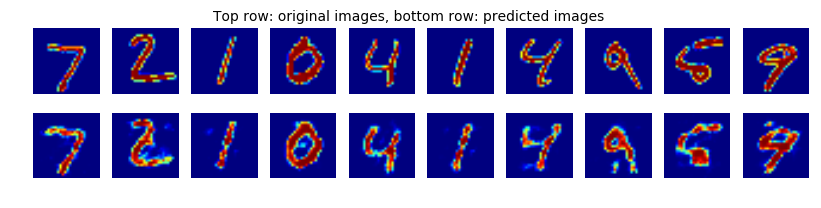

In [7]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})


        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10,frameon=False, figsize=(10, 2))
    f.suptitle('Top row: original images, bottom row: predicted images')
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
        a[0][i].axis('off')
        a[1][i].axis('off')
    plt.draw()

Keras
=====

Keras is a high-level library that can utilize TensorFlow or Theano as its backend.
Here we train a simple deep NN on the MNIST dataset.

#### Imports

In [8]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import TensorBoard
from keras.utils import np_utils

Using TensorFlow backend.


#### Hyperparameters

In [9]:
batch_size = 128
nb_classes = 10
nb_epoch = 20

#### Preprocessing

In [10]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

60000 train samples
10000 test samples


#### Model Creation

In [11]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

#### Train and Evaluate

In [13]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test), 
                    callbacks=[TensorBoard(log_dir='./logs', 
                                           histogram_freq=0, 
                                           write_graph=True,
                                           write_images=False)])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.109998893419
Test accuracy: 0.9841


Go to a terminal and type

`tensorboard --logdir=./logs`

then open the address given by the above command (usually localhost:6006) using Google Chrome.

![title](tensorboard.png)